In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from IPython.display import HTML
%matplotlib inline

import time
from keras import backend as K
import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.layers import Lambda
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import load_model

import tensorflow as tf
from Yolo_model import yolo_eval, yolo_head, yolo_body,draw_boxes

Using TensorFlow backend.


In [22]:
voc_anchors = np.array(
    [[1.3221, 1.73145], [3.19275, 4.00944], [5.05587, 8.09892], [9.47112, 4.84053], [11.2364, 10.0071]])

voc_classes = {
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
}
voc_vocab = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
num_anchors = len(voc_anchors)
anchors_tensor = K.reshape(K.variable(voc_anchors), [1, 1, 1, num_anchors, 2])


# Construct the yolo model ##


In [4]:
prev_layer = Input(shape=(416, 416, 3))
Yolo = yolo_body(prev_layer)
Yolo.summary()
Yolo.load_weights('model_data/yolo_voc_weights.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 416, 416, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 416, 416, 32)  128                                          
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 416, 416, 32)  0                                            
___________________________________________________________________________________________

In [5]:
yolo_outputs = yolo_head(Yolo.output, voc_anchors, len(voc_classes))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_outputs, input_image_shape, max_boxes=10, score_threshold=0.3,iou_threshold =  0.5)

# Apply the model to a test image

In [88]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
images = np.array(images)

In [89]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
        
def draw_boxes(image, boxes, score, classes):  
    #image = cv2.imread(image)
    i=0
    for box in boxes:
        x1 = int(box[1])
        y1 = int(box[0])
        x2 = int(box[3])
        y2 = int(box[2])
        cv2.rectangle(image,(x1,y1),( x2,y2),(0,255,0),4)
        font = cv2.FONT_HERSHEY_SIMPLEX     
        cv2.putText(image,voc_vocab[classes[i]],(x1,y1-10), font, 1,(255,255,255),3)
        cv2.putText(image,str(int(score[i]*100)),(x1+80,y1-10), font, 1,(255,255,255),3)
        i+=1
    return image   

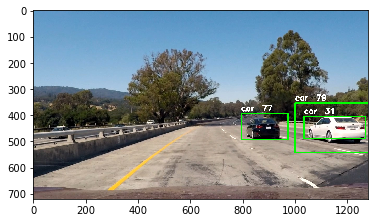

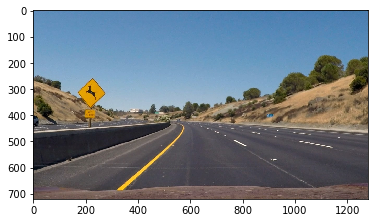

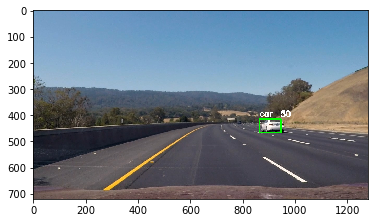

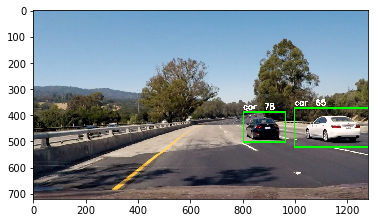

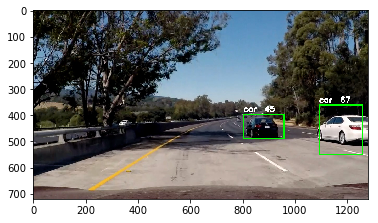

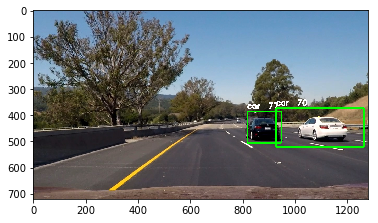

In [90]:
for image in images:
    sess = K.get_session()
    model_image_size = Yolo.layers[0].input_shape[1:3]
    image_data = cv2.resize(image, (model_image_size), interpolation = cv2.INTER_CUBIC)
    image_data = np.array(image_data, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                Yolo.input: image_data,
                input_image_shape: [image.shape[0], image.shape[1]],
                K.learning_phase(): 0
            })  
    image = draw_boxes(image, out_boxes, out_scores, out_classes)
    plt.imshow(image)
    plt.show()

# Apply to video


In [91]:
cap = cv2.VideoCapture('project_video.mp4')

sess = K.get_session()
while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        model_image_size = Yolo.layers[0].input_shape[1:3]
        image_data = cv2.resize(frame, (model_image_size), interpolation = cv2.INTER_CUBIC)
        image_data = np.array(image_data, dtype='float32')
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                Yolo.input: image_data,
                input_image_shape: [frame.shape[0], frame.shape[1]],
                K.learning_phase(): 0
            })  
        frame = draw_boxes(frame, out_boxes, out_scores, out_classes)
        cv2.imshow('frame',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    

cap.release()
cv2.destroyAllWindows()